# Demo notebook for Niimpy Exploration layer modules

## Introduction <a class="anchor" id="section_0"></a>

### *WHAT*

This notebook introduces Niimpy toolbox exploration layer module functionalities for exploratory data analysis (EDA) of digital behavioral data. The module aims to produce a summary of the data characteristics and underlying stuctures, verify their quality, and extract the relevant features from them. Module functionalities summarize the main characteristics of the data, display user and group level behavioral patterns and changes in patterns, and are usefull for assessing the data quality (e.g., missing data, outliers). The module includes functions for [plotting catogorical data](#section_1), [data counts](#section_2), [timeseries lineplots](#section_3), [punchcards](#section_4) and [visualizing missing data.](#section_5)<br>



### *FOR WHO?*
This module is for researchers analyzing longitudinal multisensor behavioral data. *EMA and digital phenotyping studies collect massive amount of complex multivariate time series data. The data analysis may be challenging due the different data types (continuous, ordinal, categorical) and the dependency between modalities. In this work, we focus on exploratory data analysis methods, that could be incorporated in the initial data analysis phase to ensure the data validity for the further analysis methods*

### *WHY*

 

*Time series data consists of ordered sequentially sampled observations, often having equally spaced sampling intervals. In contrast, cross-sectional data captures observations in a single moment of time. The temporal ordering of the time series data points is important, since the data may have important internal structure, such as autocorrelation \parencite{ts_forecasting}. Since there is dependency between consequent time series observations, changing or ignoring the order may obscure important features of the data.*

*Time series analysis is a collection of methods trying to extract relevant features and patterns, and characterize the temporally ordered data. The important characteristics include a trend, seasonality, cyclicity, heteroscedasticity, abrupt changes in the series level or variance, outlying data points, and missing data points. The trend describes the average level and of the observations, and it indicates if such level is increasing or decreasing over the time. The seasonality reveals regularly repeating patterns of crests and troughs related to calendar time (for example day, week, or year) or a time-span related to some other phenomena (such as a circadian rhythm). Cyclicity refers to repeating patterns that are not related to seasonality. The cycle length may not be constant, as in the case of periodicity. 
Heteroscedacity refers to differing variability of the observations across the time. Outlying data points might indicate some abnormality in the time series, or might occur due some error in the sampling. The missing datapoint might also reveal some information about the processes underlying the time series.*

*The time series analysis methods are divided into two classes, comprising methods operating in frequency-domain and in time-domain. The frequency-domain methods consists of spectral analysis and wavelet analysis, and the time-domain methods include auto-correlation and cross-correlation analysis. In this thesis, we will focus only on the time-domain methods. They include model fitting methods, such as Autoregressive Integrated Moving Average (ARIMA) models and ordinary regression models.*






### *HOW*

Exploration module functions are supposed to run after [data preprocessing](https://niimpy.readthedocs.io/en/latest/preprocessing/), but those can be run also on raw observations.
All the functions are implemented by using [Plotly Python Open sourde Library](https://plotly.com/python/). Plotly enables interactive visualizations which in turn makers it easier to explore different aspects of the data (e.g.,specific timerange and summary statistics).

This notebook uses several sample dataframes for module demonstration. The sample data is already preprocessed, or will be preprocessed in notebook sections before visualizations. <br> Some of the key characteristics of the data are displayed, when data is initially loaded.

All eploration module functions require the data to follow [data schema.](https://niimpy.readthedocs.io/en/latest/schema/) defined in the Niimpy toolbox [documentation](https://niimpy.readthedocs.io/en/latest/). The user must ensure that the input data follows the specified schema.

### *NOTES*

This notebook uses following definitions referring to data:
* *Feature* refers to dataframe column that stores observations (e.g., numerical sensor values, questionnaire answers)
* *User* refers to unique identifier for each subject in the data. Dataframe should also have a column named as `user`.
* *Group* refers to unique group idenfier. If subjects are grouped, dataframe shoudl have a column named as `group`.




In [1]:
%%html
<style>
table {float:left}
</style>

### Sub-module overview

The following table shows accepted data types, visualization functions and the purpose of each exploration sub-module.

| Sub-module | Data type | Functions | For what |
| :----------- | :----------- | :------------ | :------------ | 
| Categorical plot | Categorical |  Barplot | Observations counts and distributions |
| Count plot | Categorical* / Numerical | Barplot/Boxplot | Observation counts and distibutions |
| Lineplot | Numerical| Lineplot | Trend, cyclicity, patterns | 
| Punchcard | Categorical* / Numerical | Heatmap | Temporal patterns of counts or values  |
| Missingness | Categorical / Numerical | Barplot / Heatmap | Missing data patterns |

Data types denoted with \* are not compatible with every function within the module.

### Imports
Here we import modules needed for running this notebook.

In [4]:
import os
import sys
sys.path.append('../')

from pathlib import Path
import numpy as np
import pandas as pd
import niimpy
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import warnings
from niimpy.preprocessing.survey import *
from niimpy.exploration import EDA_categorical, EDA_countplot, EDA_lineplot, EDA_missingness, EDA_punchcard, setup_dataframe

### Plotly settings
Next code block defines default settings for [plotly](https://plotly.com/python/) visualizations. Feel free to adjust the settings according to your needs.

In [6]:
pio.templates.default = "seaborn"
px.defaults.template = "ggplot2"
px.defaults.color_continuous_scale = px.colors.sequential.RdBu
px.defaults.width = 1200
px.defaults.height = 482
warnings.filterwarnings("ignore")

### Table of Contents

* [Introduction](#section_0)
* [Section 1: Categorical plot](#section_1)
   * [Section 1.1 : Questionnaire summary](#section_1_1)
   * [Section 1.2 : Questionnaire grouped summary](#section_1_2)
   * [Section 1.3 : Questionnaire grouped summary score distribution](#section_1_3)
* [Section 2: Countplot](#section_2)
    * [Section 2.1 : User level observation count](#section_2_1)
    * [Section 2.2 : Group level observation count](#section_2_2)
    * [Section 2.3 : Group level value distribution](#section_2_3)
* [Section 3: Lineplot](#section_3)
    * [Section 3.1 : Lineplot](#section_3_1)
        * [Section 3.1.1 : Single user single feature](#section_3_1_1)
        * [Section 3.1.2 : Single user single feature reset index](#section_3_1_2)
        * [Section 3.1.3 : Single user single feature aggregated by day](#section_3_1_3)
    * [Section 3.2 : Multiple users single feature](#section_3_2)
    * [Section 3.3 : Group level hourly averages](#section_3_3)
    * [Section 3.4 : Group level weekday averages](#section_3_4)
* [Section 4: Punchcard](#section_4)
    * [Section 4.1 : Single user punchard](#section_4_1)
    * [Section 4.2 : Multiple user puchcard](#section_4_2)
    * [Section 4.3 : Single user punchcard showing two features](#section_4_3)    
* [Section 5: Missingness](#section_5)
    * [Section 5.1 : Data frequency by feature](#section_5_1)
    * [Section 5.2 : Average frequency by user](#section_5_2)
    * [Section 5.3 : Missingness matrix](#section_5_3)
    * [Section 5.4 : Missing data correlation](#section_5_4)


## 1) Categorical plot <a class="anchor" id="section_1"></a>

This section introduces categorical plot module visualizes **categorical data**, such as questionnaire data responses.<br>
We will demonstrate functions by using a mock survey dataframe, containing answers for:
* *Patient Health Questionnaire-2 (PHQ-2)*
* *Perceived Stress Scale (PSS10)*
* *Generalized Anxiety Disorder-2 (GAD-2)*

The data will be preprocessed, and then it's basic characteristics will be summarized before visualizations.

In [4]:
# go to parent directory
os.chdir('..')
# Get the current working directory
cwd = os.getcwd()
# Define path for data
data_folder = os.path.join(cwd,"niimpy","sampledata","mock-survey.csv")

In [5]:
# Load a mock dataframe
df = niimpy.read_csv(data_folder,tz='Europe/Helsinki')
df.head()

user  age  gender Little interest or pleasure in doing things.  \
0     1   20    Male                                 several-days   
1     2   32    Male                      more-than-half-the-days   
2     3   15    Male                      more-than-half-the-days   
3     4   35  Female                                   not-at-all   
4     5   23    Male                      more-than-half-the-days   

  Feeling down; depressed or hopeless. Feeling nervous; anxious or on edge.  \
0              more-than-half-the-days                           not-at-all   
1              more-than-half-the-days                           not-at-all   
2                           not-at-all                         several-days   
3                     nearly-every-day                           not-at-all   
4                           not-at-all              more-than-half-the-days   

  Not being able to stop or control worrying.  \
0                            nearly-every-day   
1                                several-days   
2                                  not-at-all   
3                                several-days   
4                                several-days   

  In the last month; how often have you felt that you were unable to control the important things in your life?  \
0                                       almost-never                                                              
1                                              never                                                              
2                                              never                                                              
3                                         very-often                                                              
4                                       almost-never                                                              

  In the last month; how often have you felt confident about your ability to handle your personal problems?  \
0                                          sometimes                                                          
1                                              never                                                          
2                                         very-often                                                          
3                                       fairly-often                                                          
4                                         very-often                                                          

  In the last month; how often have you felt that things were going your way?  \
0                                       fairly-often                            
1                                         very-often                            
2                                         very-often                            
3                                         very-often                            
4                                       almost-never                            

  In the last month; how often have you been able to control irritations in your life?  \
0                                              never                                     
1                                          sometimes                                     
2                                       fairly-often                                     
3                                              never                                     
4                                          sometimes                                     

  In the last month; how often have you felt that you were on top of things?  \
0                                          sometimes                           
1                                              never                           
2                                              never                           
3                                          sometimes                           
4                               

In [6]:
df.describe()

user          age
count  1000.000000  1000.000000
mean    500.500000    26.911000
std     288.819436     4.992595
min       1.000000    12.000000
25%     250.750000    23.000000
50%     500.500000    27.000000
75%     750.250000    30.000000
max    1000.000000    43.000000

The dataframe's columns are raw questions from a survey. Some questions belong to a specific category, so we will annotate them with ids. <br> The id is constructed from a prefix (the questionnaire category: GAD, PHQ, PSQI etc.), followed by the question number (1,2,3). Similarly, we will also the answers to meaningful numerical values.

**Note:** It's important that the dataframe follows the below schema before passing into niimpy.

In [7]:
# Convert column name to id, based on provided mappers from niimpy
col_id = {**PHQ2_MAP, **PSQI_MAP, **PSS10_MAP, **PANAS_MAP, **GAD2_MAP}
selected_cols = [col for col in df.columns if col in col_id.keys()]

# Convert data frame to long format
m_df = pd.melt(df, id_vars=['user', 'age', 'gender'], value_vars=selected_cols, var_name='question', value_name='answer')

# Assign questions to codes 
m_df['id'] = m_df['question'].replace(col_id)
m_df.head()

user  age  gender                                      question  \
0     1   20    Male  Little interest or pleasure in doing things.   
1     2   32    Male  Little interest or pleasure in doing things.   
2     3   15    Male  Little interest or pleasure in doing things.   
3     4   35  Female  Little interest or pleasure in doing things.   
4     5   23    Male  Little interest or pleasure in doing things.   

                    answer      id  
0             several-days  PHQ2_1  
1  more-than-half-the-days  PHQ2_1  
2  more-than-half-the-days  PHQ2_1  
3               not-at-all  PHQ2_1  
4  more-than-half-the-days  PHQ2_1

We can use a helper method to convert the answers into numerical value. The pre-defined mapper inside survey.py would be useful for this step.

In [8]:
# Transform raw answers to numerical values
m_df['answer'] = niimpy.preprocessing.survey.convert_to_numerical_answer(m_df, answer_col = 'answer',
                                question_id = 'id', id_map=ID_MAP_PREFIX, use_prefix=True)
m_df.head()

user  age  gender                                      question answer  \
0     1   20    Male  Little interest or pleasure in doing things.      1   
1     2   32    Male  Little interest or pleasure in doing things.      2   
2     3   15    Male  Little interest or pleasure in doing things.      2   
3     4   35  Female  Little interest or pleasure in doing things.      0   
4     5   23    Male  Little interest or pleasure in doing things.      2   

       id  
0  PHQ2_1  
1  PHQ2_1  
2  PHQ2_1  
3  PHQ2_1  
4  PHQ2_1

We can also produce a summary of the questionaire's score. This function can describe aggregated score over the whole population, or specific subgroups.

First we'll show statistics for the whole population:

In [9]:
d1 = niimpy.preprocessing.survey.print_statistic(m_df)
pd.DataFrame(d1)

PHQ2      PSS10      GAD2
min  0.0000   4.000000  0.000000
max  6.0000  27.000000  6.000000
avg  3.0520  14.006000  3.042000
std  1.5855   3.687759  1.536423

Statistics by the group gender:

In [10]:
d2 = niimpy.preprocessing.survey.print_statistic(m_df, group='gender')
pd.DataFrame(d2)

PHQ2                PSS10                 GAD2          
       Female      Male     Female       Male    Female      Male
min  0.000000  0.000000   4.000000   4.000000  0.000000  0.000000
max  6.000000  6.000000  27.000000  23.000000  6.000000  6.000000
avg  3.067210  3.037328  14.059063  13.954813  3.087576  2.998035
std  1.605337  1.567567   3.783230   3.596247  1.585157  1.488141

And finally statistics for PHQ questionnaires by group:

In [11]:
d3 = niimpy.preprocessing.survey.print_statistic(m_df, group='gender', prefix='PHQ')
pd.DataFrame(d3)

PHQ          
       Female      Male
min  0.000000  0.000000
max  6.000000  6.000000
avg  3.067210  3.037328
std  1.605337  1.567567

## 1.1. Questionnaire summary <a class="anchor" id="section_1_1"></a>

We can now make some plots for the preprocessed data frame. First, we can display the summary for the specific question (*PHQ-2* first question).

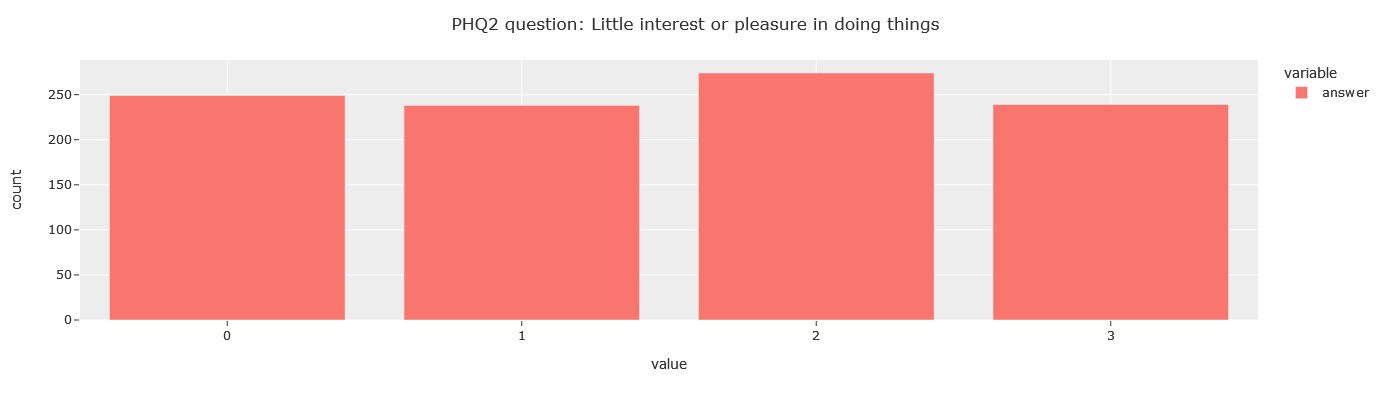

In [12]:
fig = EDA_categorical.questionnaire_summary(m_df, 
                                            question = 'PHQ2_1', 
                                            column = 'answer', 
                                            title='PHQ2 question: Little interest or pleasure in doing things', 
                                            xlabel='value', 
                                            ylabel='count', 
                                            width=600, 
                                            height=400)
fig.show()

The figure shows that the answer values (from 0 to 3) distribution is close to uniform distribution.

## 1.2. Questionnaire grouped summary <a class="anchor" id="section_1_2"></a>

We can also display the summary for each subgroup (*gender*).

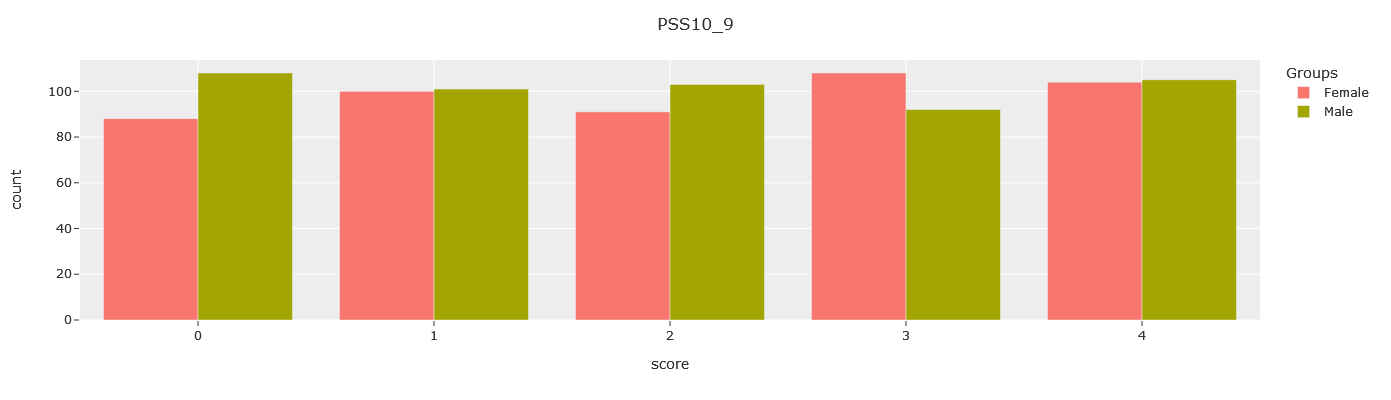

In [13]:
fig = EDA_categorical.questionnaire_grouped_summary(m_df, 
                                                    question='PSS10_9', 
                                                    group='gender', 
                                                    title='PSS10_9',
                                                    xlabel='score',
                                                    ylabel='count',
                                                    width=800,
                                                    height=400)
fig.show()

The figure shows that the differences between subgroups are not substantial.

## 1.3. Questionnaire grouped summary score distribution <a class="anchor" id="section_1_3"></a>

With some quick preprocessing, we can display the score distribution of each questionaire.

We'll extract *PSS-10* questionnaire answers from the dataframe.

In [14]:
pss_sum_df = m_df[m_df['id'].str.startswith('PSS')] \
                            .groupby(['user', 'gender']) \
                            .agg({'answer':sum}) \
                            .reset_index()
pss_sum_df['id'] = 'PSS'

We'll quickly inspect the preprocessed dataframe. 

In [15]:
pss_sum_df

user  gender  answer   id
0       1    Male      15  PSS
1       2    Male       9  PSS
2       3    Male      12  PSS
3       4  Female      16  PSS
4       5    Male      14  PSS
..    ...     ...     ...  ...
995   996  Female      17  PSS
996   997  Female      13  PSS
997   998    Male      13  PSS
998   999    Male      21  PSS
999  1000    Male      14  PSS

[1000 rows x 4 columns]

And then visualize grouped summary score distribution.

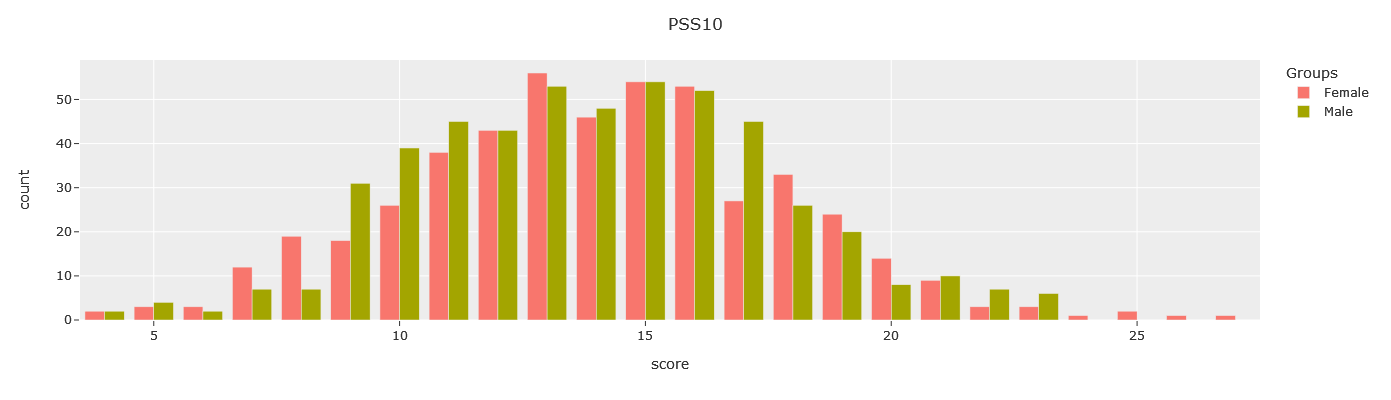

In [16]:
fig = EDA_categorical.questionnaire_grouped_summary(pss_sum_df, 
                                                    question='PSS', 
                                                    group='gender', 
                                                    title='PSS10',
                                                    xlabel='score', 
                                                    ylabel='count',
                                                    width=800, 
                                                    height=400)
fig.show()

The figure shows that the grouped summary score distrubutions are close to each other.

## 2) Countplot <a class="anchor" id="section_2"></a>
This section introduces Countplot module. The module contain functions for user and group level observation count (number of datapoints per user or group) visualization and observation value distributions.<br>
Observation counts use barplots for user level and a boxplots for group level visualizations. Boxplots are used for group level value distributions.<br>
The module assumes that the visualized **data is numerical**.

### Data
We will use sample from <a href="https://studentlife.cs.dartmouth.edu/dataset.html">StudentLife dataset</a> to demonstrate the module functions. The sample contains hourly aggregated activity data (values from 0 to 5) and group information based on pre- and post-study PHQ-9 test scores. <br> Preprocessed data sample is included in the Niimpy toolbox *sampledata* folder.

In [17]:
# Define path for data
data_path = os.path.join(cwd,"niimpy","sampledata","sl_activity.csv")
# Load data
sl = niimpy.read_csv(data_path,read_csv_options={'index_col':'timestamp'},tz='US/Eastern')
sl.index = pd.to_datetime(sl.index)
sl_loc = sl.tz_localize(None)

Before visualizations, we'll inspect the data.

In [18]:
sl_loc

user  activity group
timestamp                               
2013-03-27 06:00:00  u00         2  none
2013-03-27 07:00:00  u00         1  none
2013-03-27 08:00:00  u00         2  none
2013-03-27 09:00:00  u00         3  none
2013-03-27 10:00:00  u00         4  none
...                  ...       ...   ...
2013-05-31 18:00:00  u59         5  mild
2013-05-31 19:00:00  u59         5  mild
2013-05-31 20:00:00  u59         4  mild
2013-05-31 21:00:00  u59         5  mild
2013-05-31 22:00:00  u59         1  mild

[55907 rows x 3 columns]

In [19]:
sl_loc.describe()

activity
count  55907.000000
mean       0.750264
std        1.298238
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        5.000000

In [20]:
sl_loc.group.unique()

array(['none', 'severe', 'mild', 'moderately severe', 'moderate'],
      dtype=object)

## 2.1. User level observation count <a class="anchor" id="section_2_1"></a>
At first we visualize the number of observations for each subject.

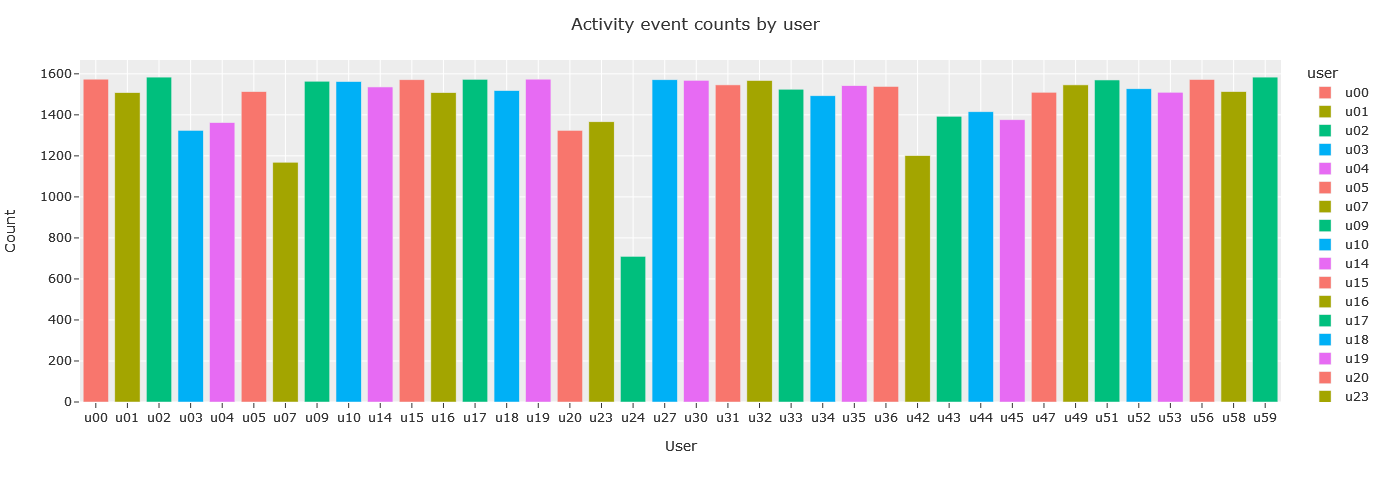

In [21]:
fig = EDA_countplot.EDA_countplot(sl, 
                                  fig_title='Activity event counts by user', 
                                  plot_type='count', 
                                  points='all',
                                  aggregation='user', 
                                  user=None, 
                                  column=None,
                                  binning=False)

fig.show()

The barplot shows that there are differences in user total activity counts. The user *u24* has the lowest event count of 710 and users *u02* and *u59* have the highest count of 1584.

## 2.2. Group level observation count <a class="anchor" id="section_2_2"></a>
Next we'll inspect group level activity event counts aggregated by day. For the improved clarity, we select a timerange of one week from the data.

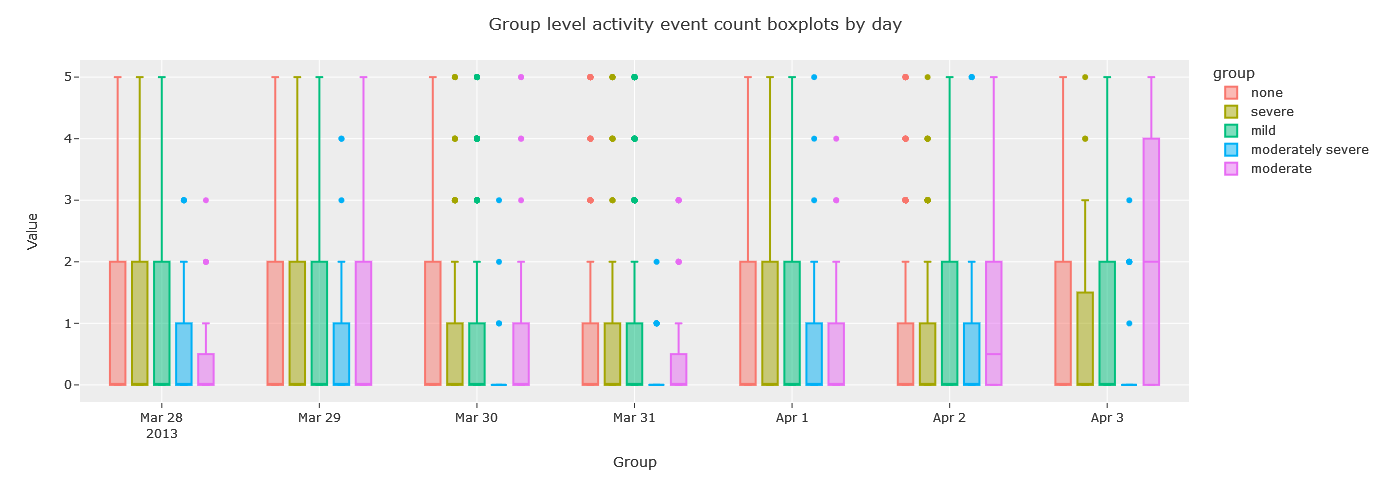

In [22]:
sl_one_week = sl_loc.loc['2013-03-28':'2013-4-3']

fig = EDA_countplot.EDA_countplot(sl_one_week, 
                                  fig_title='Group level activity event count boxplots by day', 
                                  plot_type='value', 
                                  points='all',
                                  aggregation='group', 
                                  user=None, 
                                  column='activity',
                                  binning='D')

fig.show()

The boxplot shows some variability in group level event count distributions across the days spanning from Mar 28 to Apr 3 2013.

## 2.3. Group level value distributions <a class="anchor" id="section_2_3"></a>
Finally we visualize group level activity value distributions.

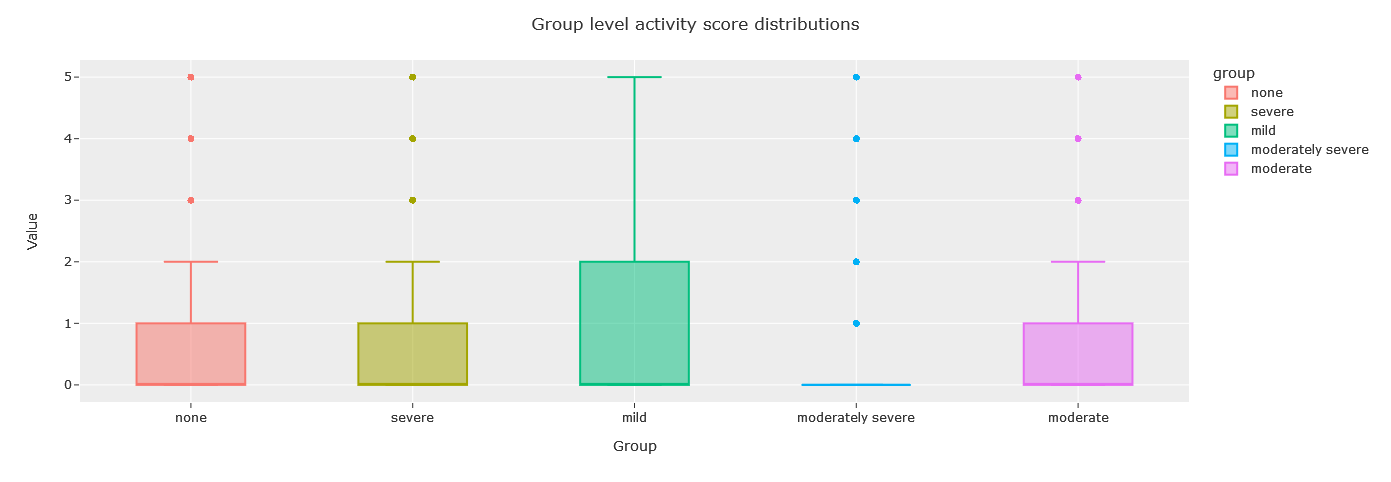

In [23]:
fig = EDA_countplot.EDA_countplot(sl,
                                  fig_title='Group level activity score distributions', 
                                  plot_type='value', 
                                  points='outliers',
                                  aggregation='group', 
                                  user=None,
                                  column='activity',
                                  binning=False)

fig.show()

The boxplot shows that activity score distribution for groups *mild* and *moderately severe* differ from the rest.

## 3. Lineplot <a class="anchor" id="section_3"></a>


This section introduces Lineplot module functions. We use the same <a href="https://studentlife.cs.dartmouth.edu/dataset.html">StudentLife dataset</a> derived activity data as in previous section.

## 3.1. Lineplot <a class="anchor" id="section_3_1"></a>

Lineplot functions display **numerical feature values** on time axis. The user can optionally resample (downsample) and smoothen the data for better visual clarity.

## 3.1.1. Single user single feature <a class="anchor" id="section_3_1_1"></a>
At first, we'll visualize single user single feature data, without resampling or smoothing. 

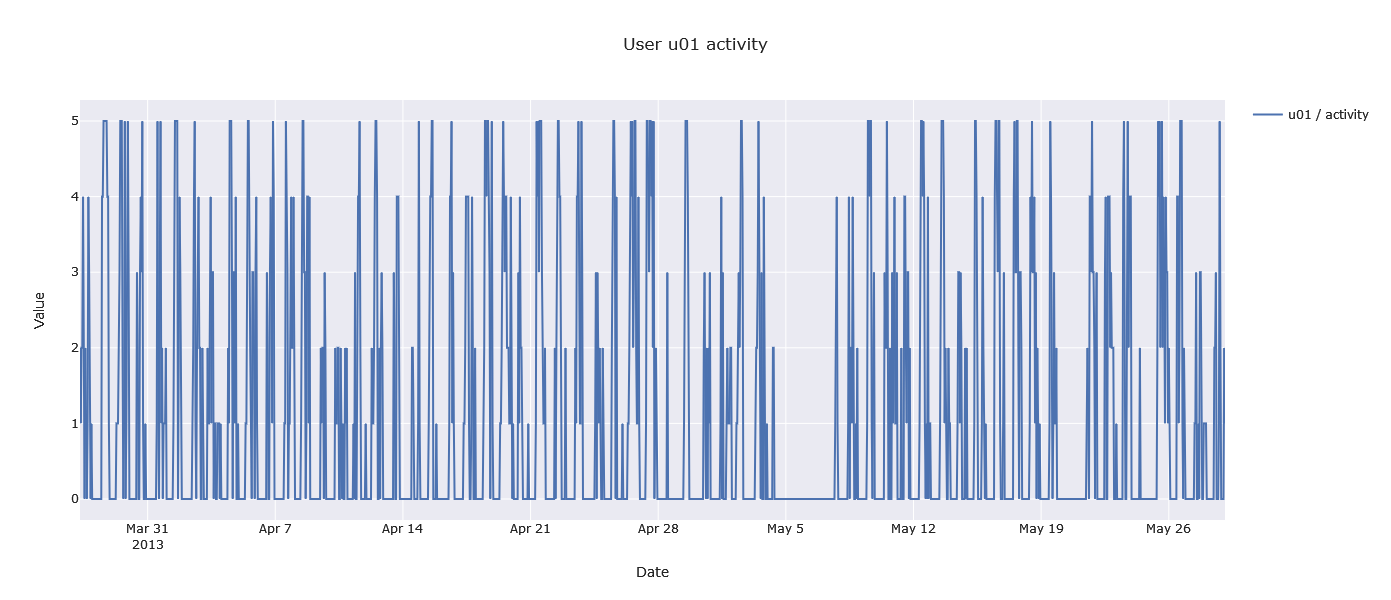

In [24]:
fig = EDA_lineplot.timeplot(sl_loc,
                            users=['u01'],
                            columns=['activity'],
                            title='User {} activity'.format('u01'),
                            xlabel='Date',
                            ylabel='Value',
                            resample=False,
                            interpolate=False,
                            window=1,
                            reset_index=False)

fig.show()

The figure showing all the activity datapoints is difficult to interpet. By zooming in the time range, the daily patters come apparent. There is no or low activity during the night.

## 3.1.2. Single user single feature index resetted <a class="anchor" id="section_3_1_2"></a>
Next, we'll plot visualize the same data using resampling by hour, and 24 hour rolling window smoothing for improved visualization clarity. We also reset the index, showing now hours from the first activity feature observation.

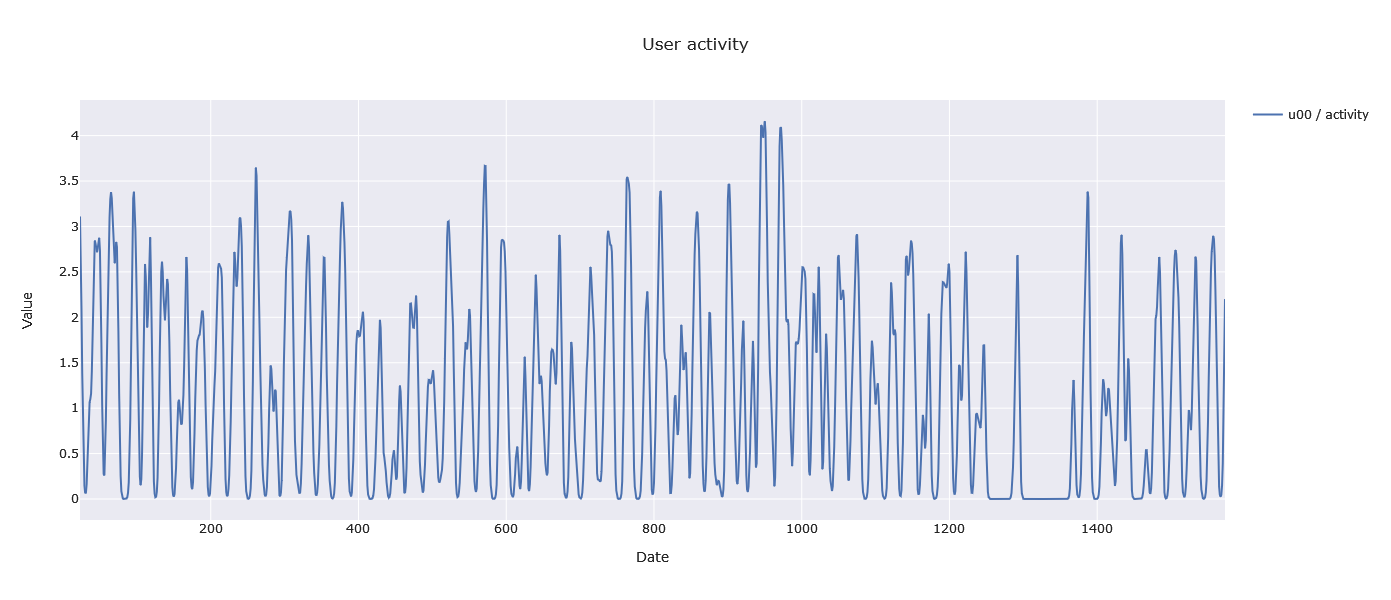

In [25]:
fig = EDA_lineplot.timeplot(sl_loc,
                            users=['u00'],
                            columns=['activity'],
                            title='User activity',
                            xlabel='Date',
                            ylabel='Value',
                            resample='H',
                            interpolate=True,
                            window=24,
                            reset_index=True)

fig.show()

By zoomin in the smoothed lineplot, daily activity patterns are easier to detect.

## 3.1.3. Single user single feature, aggregated by day <a class="anchor" id="section_3_1_3"></a>
Next visualization shows resamplig by day and 7 day rolling window smoothing, making the activity time series trend visible.   

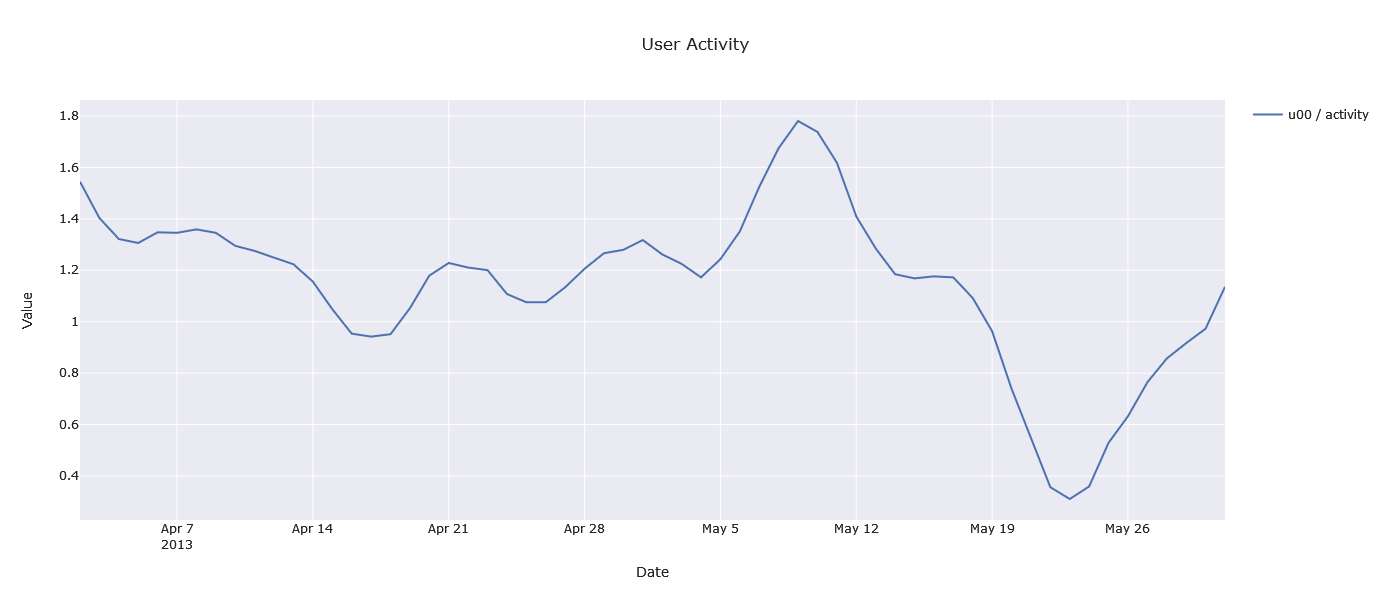

In [26]:
fig = EDA_lineplot.timeplot(sl_loc,
                            users=['u00'],
                            columns=['activity'],
                            title='User Activity' ,
                            xlabel='Date',
                            ylabel='Value',
                            resample='D',
                            interpolate=True,
                            window=7)

fig.show()

Daily aggregated and smoothed data makes the user activity trend visible. There is a peak at May 9 and the crest at May 23.

## 3.2. Multiple subjects single feature <a class="anchor" id="section_3_2"></a>
The following visualization superimposes three subject's activity on same figure. 

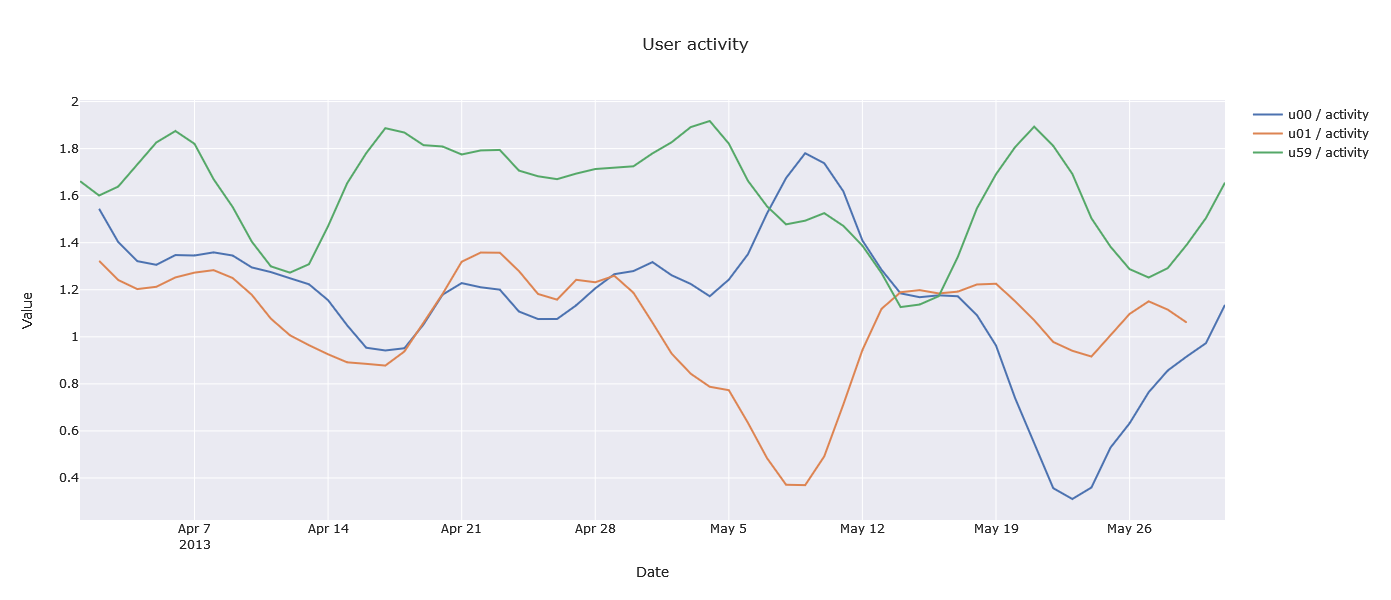

In [27]:
fig = EDA_lineplot.timeplot(sl_loc,
                            users=['u00','u01','u59'],
                            columns=['activity'],
                            title='User activity',
                            xlabel='Date',
                            ylabel='Value',
                            resample='D',
                            interpolate=True,
                            window=7)

fig.show()

## 3.3. Group level hourly averages <a class="anchor" id="section_3_3"></a>
Next we'll compare group level hourly average activity.

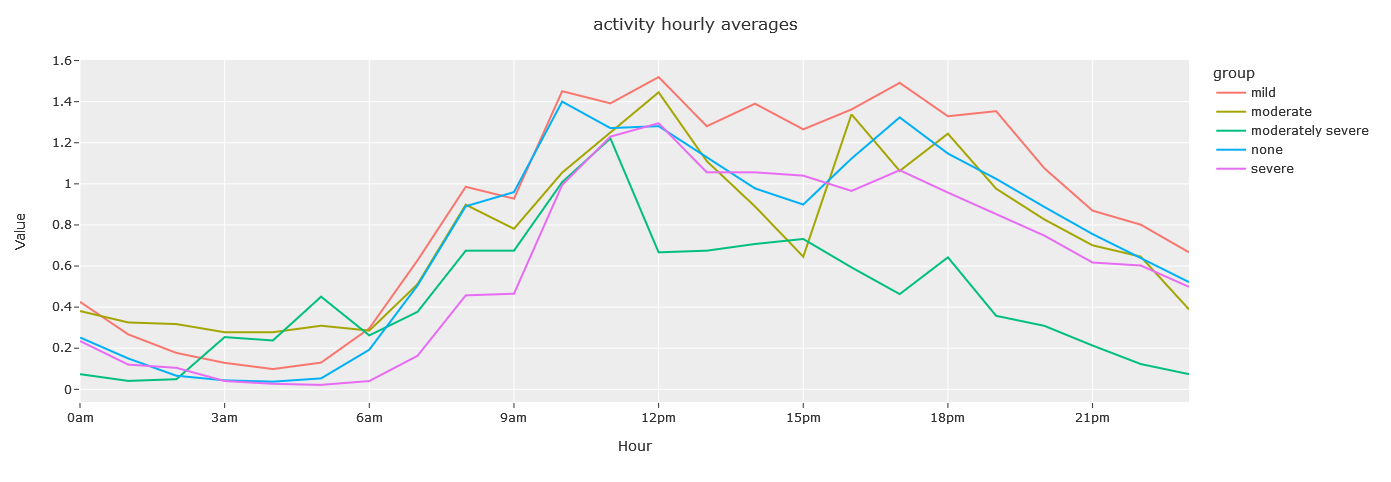

In [28]:
fig = EDA_lineplot.timeplot(sl_loc,
                            users='Group',
                            columns=['activity'],
                            title='User Activity',
                            xlabel='Date',
                            ylabel='Value',
                            resample='D',
                            interpolate=True,
                            window=7,
                            reset_index=False,
                            by='hour')

fig.show()

## 3.4. Group level weekday averages <a class="anchor" id="section_3_4"></a>
And finally, 

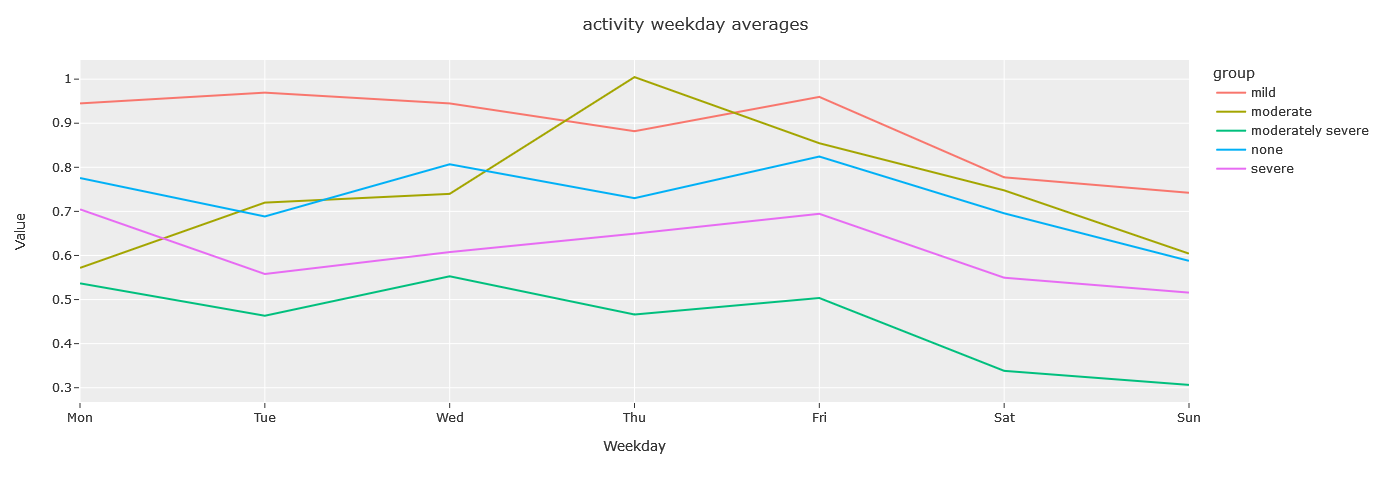

In [29]:
fig = EDA_lineplot.timeplot(sl_loc,
                            users='Group',
                            columns=['activity'],
                            title='User Activity',
                            xlabel='Date',
                            ylabel='Value',
                            resample='D',
                            interpolate=True,
                            window=7,
                            reset_index=False,
                            by='weekday')

fig.show()

## 4. Punchcard <a class="anchor" id="section_4"></a>
This section introduces Punchcard module functions. The functions aggregate the data and show the averaged value for each timepoint. <br> We use the same StudentLife dataset derived activity data as in two previous sections.

## 4.1. Single user punchcard <a class="anchor" id="section_4_1"></a>
At first we visualize one daily aggregated mean activity for single subject. We'll change the plot color to grayscale for improved clarity.


In [30]:
px.defaults.color_continuous_scale = px.colors.sequential.gray

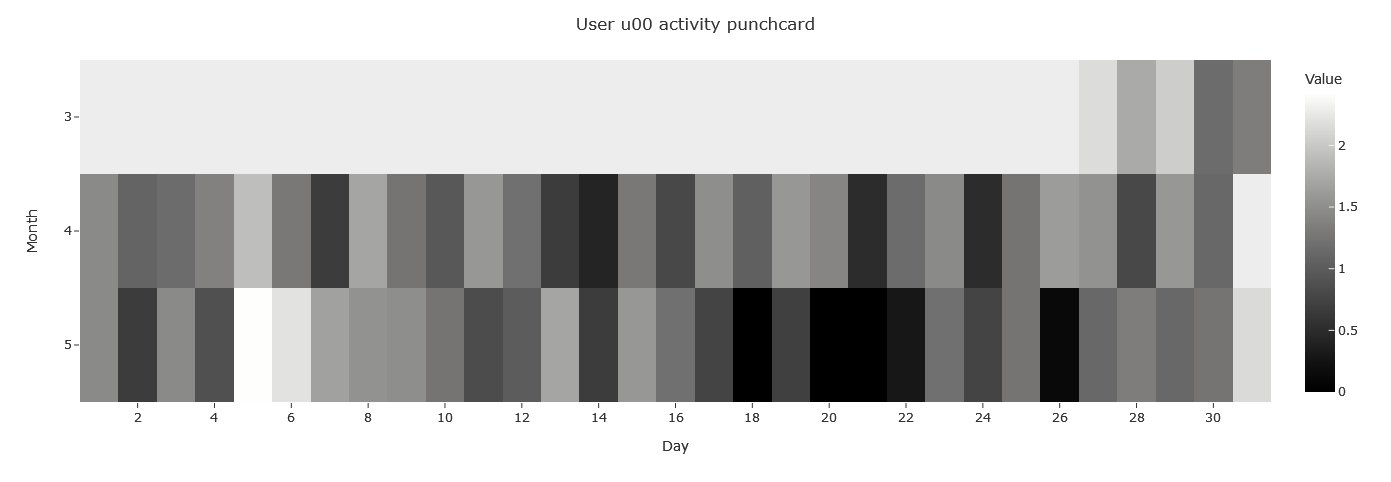

In [31]:
EDA_punchcard.punchcard_plot(sl, 
                             user_list=['u00'],
                             columns=['activity'],
                             title="User {} activity punchcard".format('u00'),
                             resample='D',
                             normalize=False,
                             agg_func=np.mean,
                             timerange=False)

## 4.2. Multiple user punchcard <a class="anchor" id="section_4_2"></a>
Next, we'll visualize mean activity for multiple subjects.

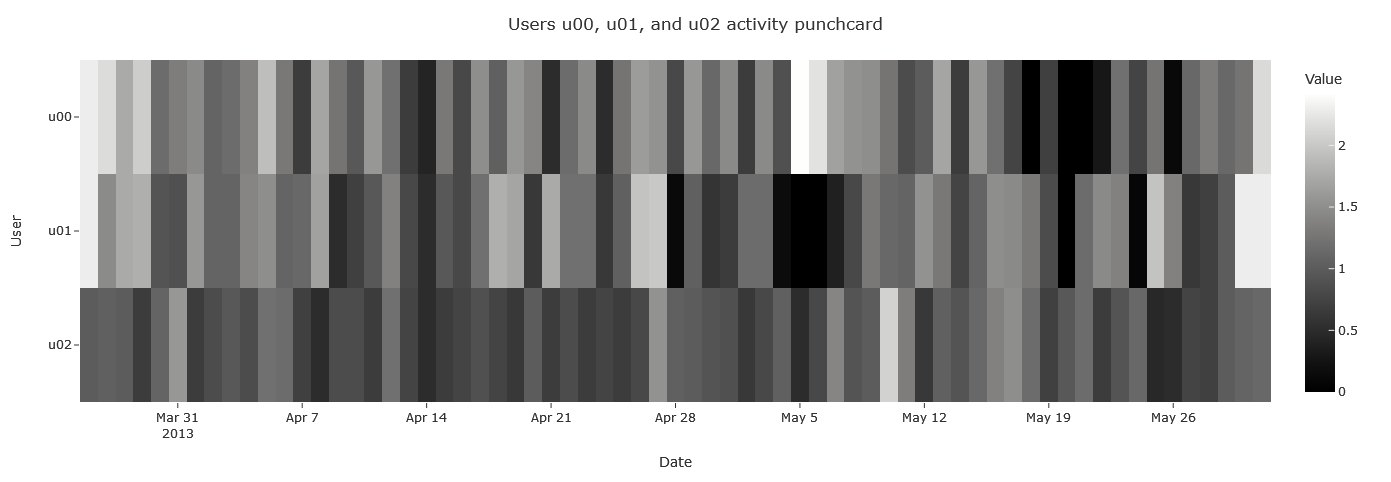

In [32]:
EDA_punchcard.punchcard_plot(sl, 
                             user_list=['u00','u01','u02'],
                             columns=['activity'],
                             title="Users {}, {}, and {} activity punchcard".format('u00','u01','u02'),
                             resample='D',
                             normalize=False,
                             agg_func=np.mean,
                             timerange=False)

## 4.3. Single user punchcard showing two features <a class="anchor" id="section_4_3"></a>
Lastly, we'll visualize daily aggregated single user activity side by side with activity of previous week. <br>
We start by shifting the activity by one week and by adding it to the original dataframe. 

In [33]:
sl_loc['previous_week_activity'] = sl_loc['activity'].shift(periods=7, fill_value=0)

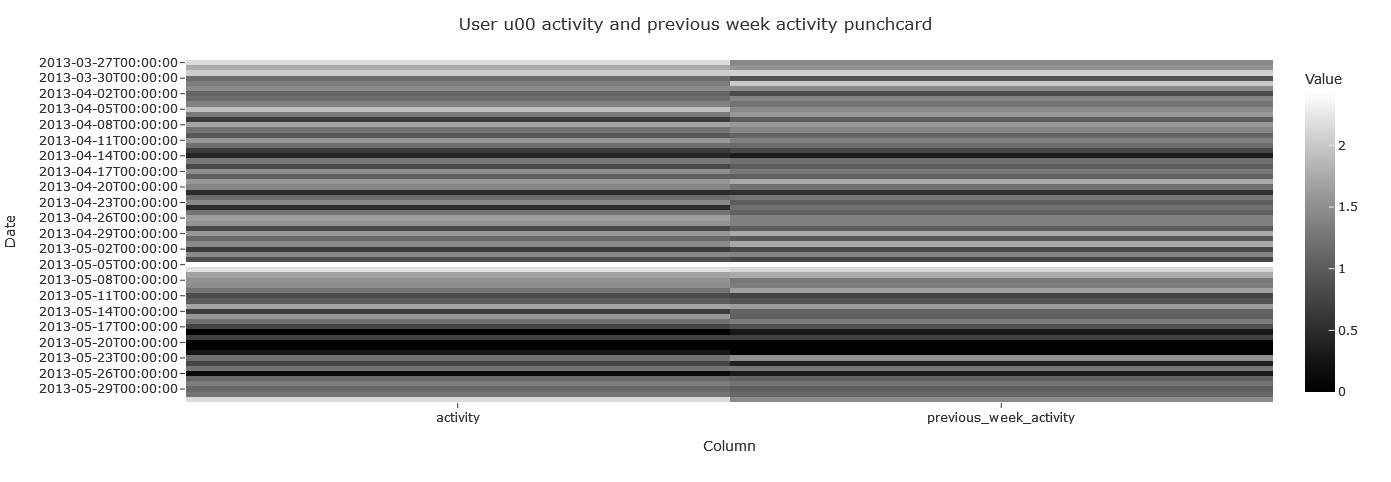

In [34]:
EDA_punchcard.punchcard_plot(sl_loc, 
                             user_list=['u00'],
                             columns=['activity','previous_week_activity'],
                             title="User {} activity and previous week activity punchcard".format('u00'),
                             resample='D',
                             normalize=False,
                             agg_func=np.mean,
                             timerange=False)

## 5) Missingness <a class="anchor" id="section_5"></a>
This sections introduces Missingness module for missing data inspection. The module features data missingness visualizations by frequency and by timepoint.<br>
Additionally, it offers an option for missing data correlation visualization.   

### Data 

For data missingness visualizations, we'll create a mock dataframe with missing values using `niimpy.util.create_missing_dataframe` function.

In [35]:
df_m = setup_dataframe.create_missing_dataframe(nrows=2*24*14, ncols=5, density=0.7, index_type='dt', freq='10T')
df_m.columns = ['User_1','User_2','User_3','User_4','User_5',]

We will quickly inspect the dataframe before the visualizations.

In [36]:
df_m

User_1     User_2     User_3     User_4     User_5
2022-01-01 00:00:00  10.979388        NaN  18.567203  72.458286        NaN
2022-01-01 00:10:00  56.062922  91.476566  20.252438  16.483021   9.278226
2022-01-01 00:20:00  22.260378  26.854581  75.850521  16.547701  65.135479
2022-01-01 00:30:00  87.848150  43.934596  40.651122        NaN  50.894629
2022-01-01 00:40:00        NaN  14.570537        NaN   6.316385        NaN
...                        ...        ...        ...        ...        ...
2022-01-05 15:10:00        NaN  90.725441  42.077203  59.878489  56.910059
2022-01-05 15:20:00        NaN  42.364681   4.002440  28.603142  48.004890
2022-01-05 15:30:00  37.770960        NaN  85.387456  67.286025  75.741787
2022-01-05 15:40:00  15.117966        NaN   4.949615  58.436874  19.315027
2022-01-05 15:50:00  30.272354        NaN        NaN  75.945916  52.336514

[672 rows x 5 columns]

In [37]:
df_m.describe()

User_1      User_2      User_3      User_4      User_5
count  471.000000  463.000000  484.000000  449.000000  485.000000
mean    51.301529   50.666692   50.274556   50.237370   49.539262
std     28.965912   29.118694   28.648561   28.304949   29.620412
min      1.293590    1.043517    1.115804    1.565771    1.037237
25%     25.803462   25.889423   26.578839   27.378577   23.945569
50%     50.074741   51.149907   47.727581   49.389826   47.453873
75%     75.387946   76.957005   75.898746   74.309067   75.807780
max     99.989271   99.240716   99.807324   99.859837   99.430244

## 5.1. Data frequency by feature <a class="anchor" id="section_5_1"></a>

First, we create a histogram to visualize data frequency per column.

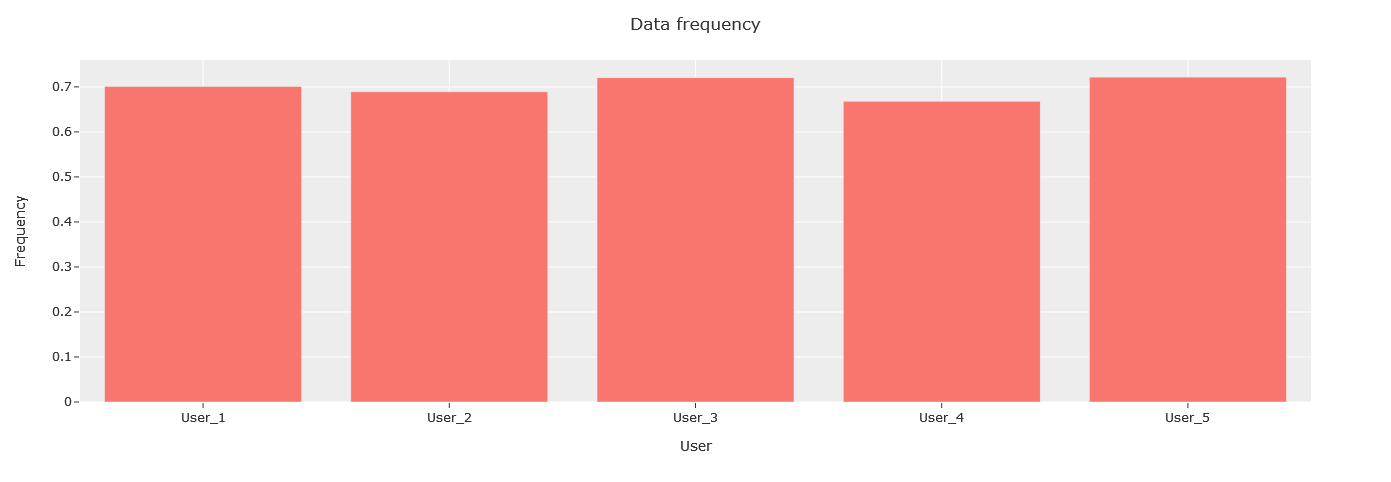

In [38]:
fig = EDA_missingness.bar(df_m,
                          xaxis_title='User',
                          yaxis_title='Frequency')
fig.show()

## 5.2. Average frequency by user <a class="anchor" id="section_5_2"></a>
NEext, we will show average data frequency for all users.

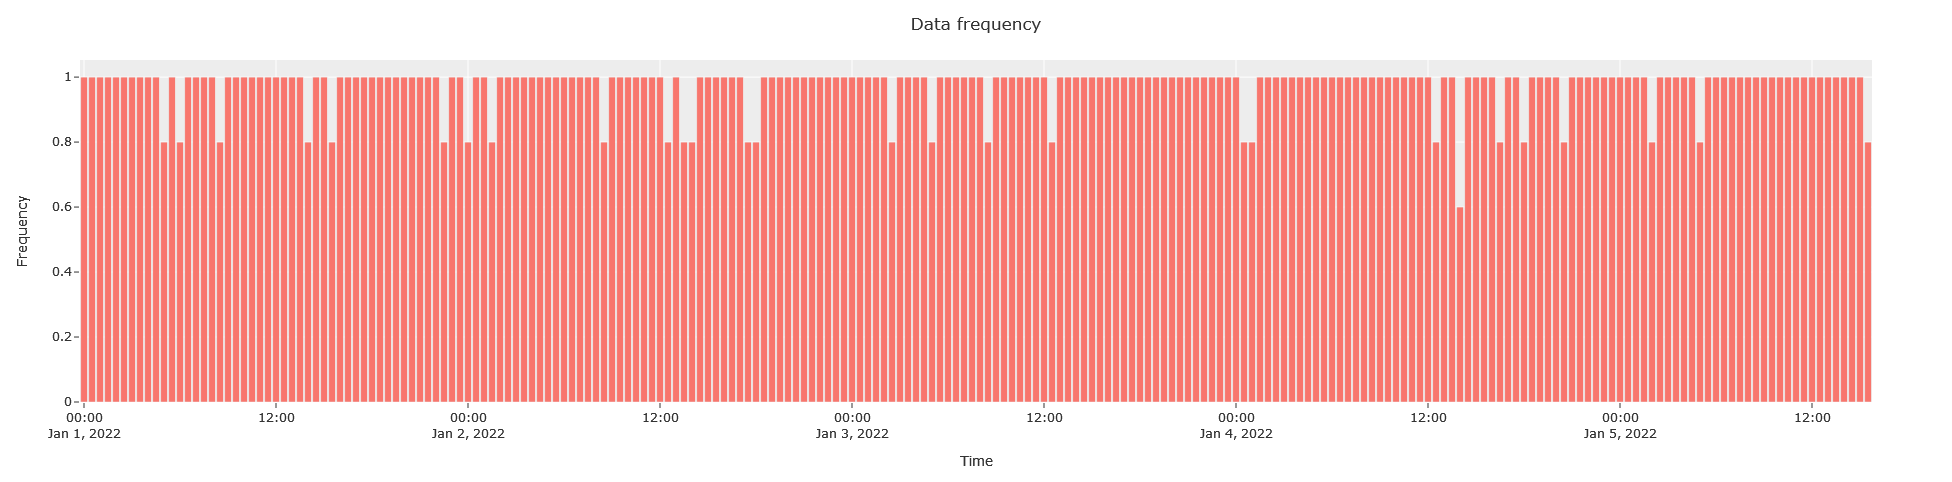

In [39]:
fig = EDA_missingness.bar(df_m, 
                          sampling_freq='30T',
                          xaxis_title='Time',
                          yaxis_title='Frequency')
fig.show()

## 5.3. Missingness matrix <a class="anchor" id="section_5_3"></a>
We can also create a missingness matrix visualization for the dataframe. The matrix show data missingess by a timepoint.

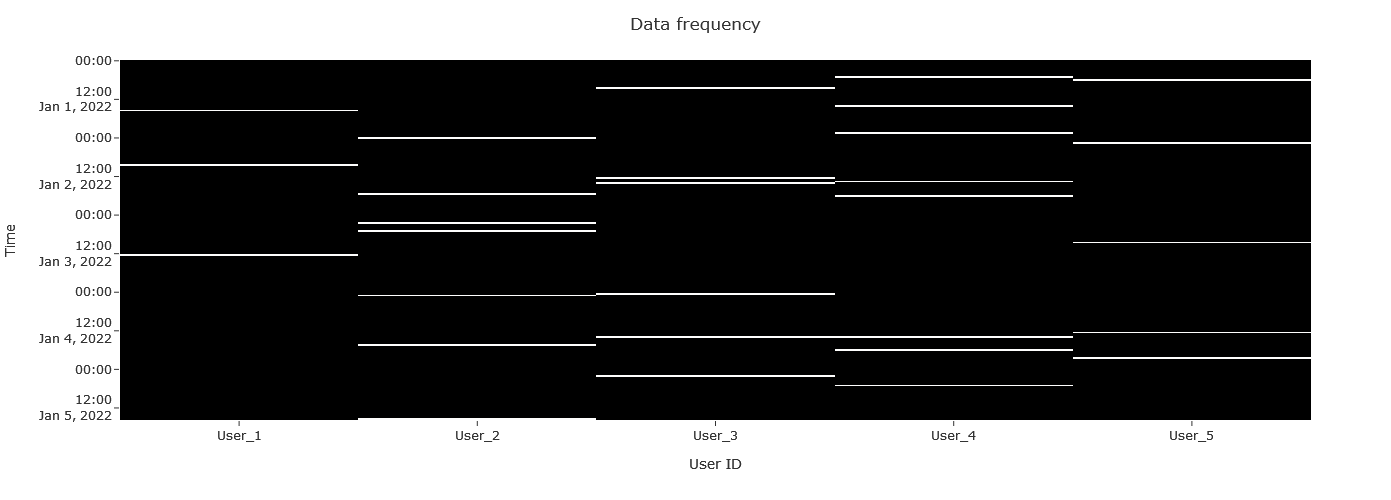

In [40]:
fig = EDA_missingness.matrix(df_m,
                             sampling_freq='30T',
                             xaxis_title="User ID",
                             yaxis_title="Time")
fig.show()

## 5.4. Missing data correlations <a class="anchor" id="section_5_4"></a>

Finally, we plot a heatmap to display the correlations between missing data.

Correlation ranges from -1 to 1: 
* -1 means that if one variable appears then the other will be missing. 
* 0 means that there is no correlation between the missingness of two variables. 
* 1 means that the two variables will always appear together.

### Data
For the correlations, we use *NYC collision factors* [sample data](https://github.com/ResidentMario/missingno). 

In [41]:
collisions = pd.read_csv("https://raw.githubusercontent.com/ResidentMario/missingno-data/master/nyc_collision_factors.csv")

In [42]:
collisions

DATE      TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0     11/10/2016  16:11:00   BROOKLYN   11208.0  40.662514 -73.872007   
1     11/10/2016  05:11:00  MANHATTAN   10013.0  40.721323 -74.008344   
2     04/16/2016  09:15:00   BROOKLYN   11201.0  40.687999 -73.997563   
3     04/15/2016  10:20:00     QUEENS   11375.0  40.719228 -73.854542   
4     04/15/2016  10:35:00   BROOKLYN   11210.0  40.632147 -73.952731   
...          ...       ...        ...       ...        ...        ...   
7298  01/07/2016  21:30:00   BROOKLYN   11235.0  40.584305 -73.959113   
7299  01/06/2016  12:50:00   BROOKLYN   11220.0  40.638583 -74.020772   
7300  01/04/2016  17:45:00   BROOKLYN   11235.0  40.581744 -73.953836   
7301  01/02/2016  17:20:00  MANHATTAN   10016.0  40.750960 -73.982723   
7302  01/02/2016  20:00:00   BROOKLYN   11213.0  40.663604 -73.934391   

                       LOCATION      ON STREET NAME CROSS STREET NAME  \
0     (40.6625139, -73.8720068)      WORTMAN AVENUE    MONTAUK AVENUE   
1     (40.7213228, -74.0083444)       HUBERT STREET     HUDSON STREET   
2     (40.6879989, -73.9975625)        HENRY STREET     WARREN STREET   
3     (40.7192276, -73.8545422)                 NaN               NaN   
4     (40.6321467, -73.9527315)      BEDFORD AVENUE       CAMPUS ROAD   
...                         ...                 ...               ...   
7298  (40.5843046, -73.9591125)      EAST 11 STREET       BLAKE COURT   
7299  (40.6385828, -74.0207721)            4 AVENUE         64 STREET   
7300  (40.5817444, -73.9538363)     SHORE BOULEVARD        CASS PLACE   
7301  (40.7509597, -73.9827227)      WEST 38 STREET          5 AVENUE   
7302  (40.6636039, -73.9343912)  SCHENECTADY AVENUE  EMPIRE BOULEVARD   

         OFF STREET NAME  ...  CONTRIBUTING FACTOR VEHICLE 1  \
0                    NaN  ...  Failure to Yield Right-of-Way   
1                    NaN  ...  Failure to Yield Right-of-Way   
2                    NaN  ...             Lost Consciousness   
3     67-64 FLEET STREET  ...  Failure to Yield Right-of-Way   
4                    NaN  ...  Failure to Yield Right-of-Way   
...                  ...  ...                            ...   
7298                 NaN  ...             Lost Consciousness   
7299                 NaN  ...  Failure to Yield Right-of-Way   
7300                 NaN  ...  Failure to Yield Right-of-Way   
7301                 NaN  ...             Lost Consciousness   
7302                 NaN  ...             Lost Consciousness   

      CONTRIBUTING FACTOR VEHICLE 2  CONTRIBUTING FACTOR VEHICLE 3  \
0                       Unspecified                            NaN   
1                               NaN                            NaN   
2                Lost Consciousness                            NaN   
3     Failure to Yield Right-of-Way  Failure to Yield Right-of-Way   
4     Failure to Yield Right-of-Way                            NaN   
...                             ...                            ...   
7298                    Unspecified                            NaN   
7299                    Unspecified                            NaN   
7300                    Unspecified                            NaN   
7301             Lost Consciousness                            NaN   
7302                    Unspecified                            NaN   

      CONTRIBUTING FACTOR VEHICLE 4  CONTRIBUTING FACTOR VEHICLE 5  \
0                               NaN                            NaN   
1                               NaN                            NaN   
2                               NaN                            NaN   
3                               NaN                            NaN   
4                               NaN                            NaN   
...                             ...                            ...   
7298                            NaN                            NaN   
7299                            NaN                            NaN   
7300              

In [43]:
collisions.describe()

ZIP CODE     LATITUDE    LONGITUDE  NUMBER OF PERSONS INJURED  \
count   6919.000000  7303.000000  7303.000000                7303.000000   
mean   10900.746640    40.717653   -73.921406                   0.350678   
std      551.568724     0.069437     0.083317                   0.707873   
min    10001.000000    40.502341   -74.248277                   0.000000   
25%    10310.000000    40.670865   -73.980744                   0.000000   
50%    11211.000000    40.723260   -73.933888                   0.000000   
75%    11355.000000    40.759527   -73.864463                   1.000000   
max    11694.000000    40.909628   -73.702590                  16.000000   

       NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
count               7303.000000                    7303.000000   
mean                   0.000959                       0.133644   
std                    0.030947                       0.362129   
min                    0.000000                       0.000000   
25%                    0.000000                       0.000000   
50%                    0.000000                       0.000000   
75%                    0.000000                       0.000000   
max                    1.000000                       3.000000   

       NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLISTS INJURED  \
count                   7303.000000                         0.0   
mean                       0.000822                         NaN   
std                        0.028653                         NaN   
min                        0.000000                         NaN   
25%                        0.000000                         NaN   
50%                        0.000000                         NaN   
75%                        0.000000                         NaN   
max                        1.000000                         NaN   

       NUMBER OF CYCLISTS KILLED  
count                        0.0  
mean                         NaN  
std                          NaN  
min                          NaN  
25%                          NaN  
50%                          NaN  
75%                          NaN  
max                          NaN

Finally, we will visualize the correlations by a heatmap and a dendrogram.

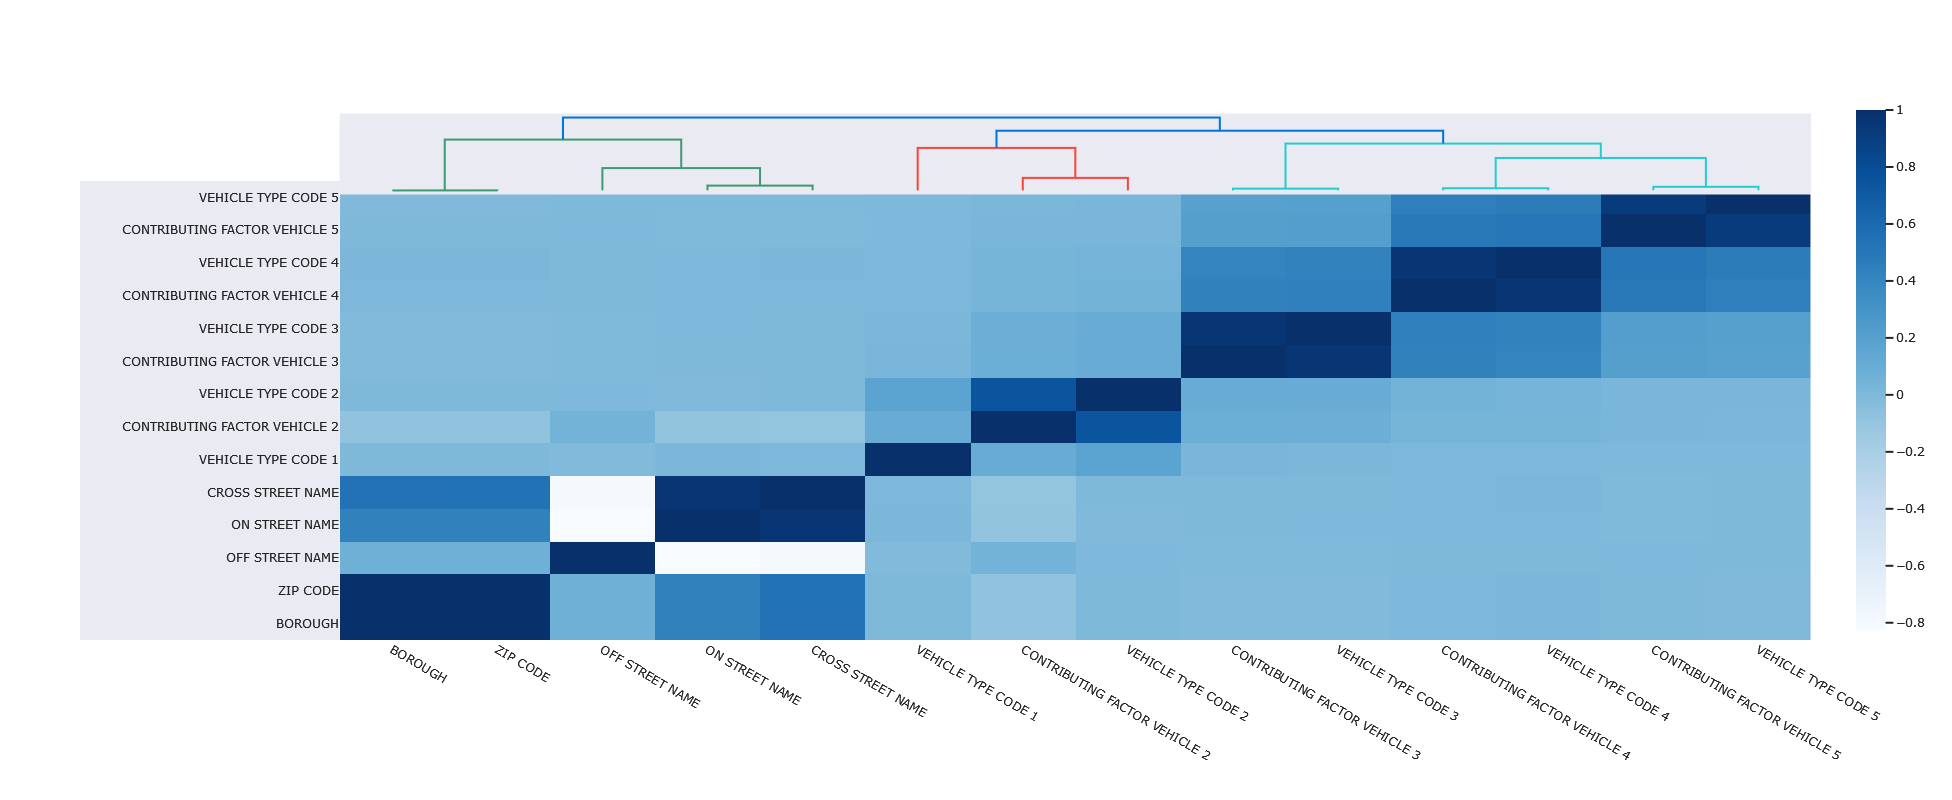

In [44]:
fig = EDA_missingness.heatmap(collisions)
fig.show()